In [2]:
from bs4 import BeautifulSoup
import pdb
import pandas as pd
import re
from datetime import datetime
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Verify base data

Check that all 122 table entries made it into the raw data file

In [3]:
with open("data/pepperscale_data.html", "r") as raw_html:
    pepper_html = BeautifulSoup(raw_html, 'html.parser')
    prettified_html = pepper_html.prettify()
    
with open("data/prettified_pepperscale_data.html", "w") as f:
    f.write(prettified_html.encode('utf8'))

From spot check: tr class "even" and "odd" indicate top of row; there should be 122 entries, as there was on the site

In [4]:
len(pepper_html.find_all("tr", re.compile("even|odd")))

122

## Extract information

Process each pepper

Schema
- Name
- Heat (SHU)
- Jalapeño Reference Point
- Species
- Origin
- Link

Notes

- Can drop "child" tags with detailed information because info is in "tr even/odd" tags and child tags don't have min/max values
- Detailed information is unlabeled, but after min/max follows child tag order: "Heat", "JalRP", "Species", "Origin"
- Account for unicode characters in pepper names

In [5]:
INFO_LABELS = ["name", "min_shu", "max_shu", "heat", "jrp", "species", "origin", "link"]

In [6]:
pepper_tags = pepper_html.find_all("tr", re.compile("even|odd"))

In [7]:
test_row = pepper_tags[0]
test_row

<tr class="odd parent" role="row"><td style="" tabindex="0">Bell Pepper</td><td><a href="http://www.pepperscale.com/bell-pepper" rel="noopener noreferrer" target="_blank">pepperscale.com</a></td><td>0</td><td class="sorting_1">0</td><td style="display: none;">Mild</td><td style="display: none;">-8,000 to -2,500</td><td style="display: none;">annuum</td><td style="display: none;">Mexico and South America</td></tr>

In [8]:
def extract_info_from_row_tag(row_tag):
    """Extract pepper info from tag; ignore non-pepper-related info"""
    pepper_info = [element.text.encode("utf-8") for element in row_tag.contents if element.text != "pepperscale.com"]
    link = row_tag.find("a").get('href')
    return dict(zip(INFO_LABELS, pepper_info + [link]))

all_peppers = [extract_info_from_row_tag(pepper_row) for pepper_row in pepper_tags]
all_peppers

[{'heat': 'Mild',
  'jrp': '-8,000 to -2,500',
  'link': u'http://www.pepperscale.com/bell-pepper',
  'max_shu': '0',
  'min_shu': '0',
  'name': 'Bell Pepper',
  'origin': 'Mexico and South America',
  'species': 'annuum'},
 {'heat': 'Mild',
  'jrp': '-8,000 to -2,500',
  'link': u'http://www.pepperscale.com/gypsy-pepper',
  'max_shu': '0',
  'min_shu': '0',
  'name': 'Gypsy Pepper',
  'origin': 'USA',
  'species': 'annuum'},
 {'heat': 'Mild',
  'jrp': '-8,000 to -2,500',
  'link': u'http://www.pepperscale.com/purple-beauty-pepper',
  'max_shu': '0',
  'min_shu': '0',
  'name': 'Purple Beauty Pepper',
  'origin': 'South America',
  'species': 'annuum'},
 {'heat': 'Mild',
  'jrp': '-8,000 to -2,500',
  'link': u'http://www.pepperscale.com/melrose-pepper',
  'max_shu': '0',
  'min_shu': '0',
  'name': 'Melrose Pepper',
  'origin': 'USA',
  'species': 'annuum'},
 {'heat': 'Mild',
  'jrp': '-8,000 - 2,500',
  'link': u'http://www.pepperscale.com/peperone-di-senise/',
  'max_shu': '0',
  '

## Validate & sanitize data

In [9]:
peppers_data = pd.DataFrame(all_peppers)[INFO_LABELS]
peppers_data.head()

,name,min_shu,max_shu,heat,jrp,species,origin,link
0,Bell Pepper,0,0,Mild,"-8,000 to -2,500",annuum,Mexico and South America,http://www.pepperscale.com/bell-pepper
1,Gypsy Pepper,0,0,Mild,"-8,000 to -2,500",annuum,USA,http://www.pepperscale.com/gypsy-pepper
2,Purple Beauty Pepper,0,0,Mild,"-8,000 to -2,500",annuum,South America,http://www.pepperscale.com/purple-beauty-pepper
3,Melrose Pepper,0,0,Mild,"-8,000 to -2,500",annuum,USA,http://www.pepperscale.com/melrose-pepper
4,Peperone Di Senise,0,0,Mild,"-8,000 - 2,500",annuum,Italy,http://www.pepperscale.com/peperone-di-senise/


### Names

- Have to be unique

In [10]:
peppers_data["name"].nunique() == len(peppers_data)

True

### Min/Max SHU (Scoville Heat Units)

In [11]:
# min/max currently strings
peppers_data["min_shu"].values[0]

'0'

In [16]:
(~peppers_data["min_shu"].str.isdigit()).sum()

1

In [186]:
def sanitize_shu(shu):
    """astype(errors="ignore") throwing NA error"""
    try:
        return int(shu)
    except:
        return None

In [187]:
peppers_data["min_shu"] = peppers_data["min_shu"].apply(sanitize_shu)
peppers_data["max_shu"] = peppers_data["max_shu"].apply(sanitize_shu)

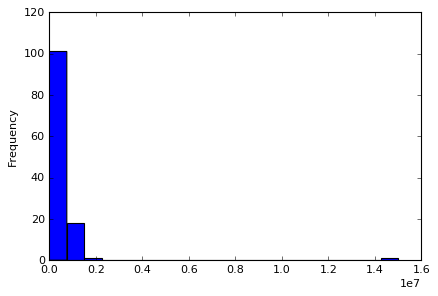

In [263]:
peppers_data["min_shu"].plot.hist(bins=20)

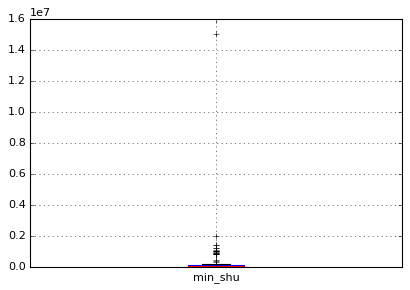

In [278]:
peppers_data.boxplot("min_shu")

In [279]:
# huge jump in SHU - definitely some major outliers in the scale here
peppers_data[peppers_data["min_shu"] > 500000].sort_values("min_shu").head(10)

,name,min_shu,max_shu,heat,jrp,species,origin,link,min_jrp,max_jrp,region
102,Bhut Jolokia Chocolate,800000.0,1001304,Super Hot,100 to 400,chinense,India,http://www.pepperscale.com/bhut-jolokia-chocolate,100,400,Asia
111,Trinidad Scorpion “Butch T”,800000.0,1463700,Super Hot,100 to 585,chinense,Australia,https://www.pepperscale.com/trinidad-scorpion-...,100,585,Australia and Oceania
105,7 Pot Jonah,800000.0,1200000,Super Hot,100 to 480,chinense,Trinidad,https://www.pepperscale.com/7-pot-jonah/,100,480,Central America and the Caribbean
107,7 Pot Primo,800000.0,1268250,Super Hot,100 to 507,chinense,United States of America,https://www.pepperscale.com/7-pot-primo/,100,507,North America
101,7 Pot Bubblegum,850000.0,1000000,Super Hot,106 to 400,chinense,United Kingdom,https://www.pepperscale.com/7-pot-bubblegum/,106,400,Europe
103,Ghost Pepper,855000.0,1041427,Super Hot,107 to 417,chinense,India,http://www.pepperscale.com/ghost-pepper,107,417,Asia
110,Naga Viper,900000.0,1382118,Super Hot,113 to 553,chinense,United Kingdom,https://www.pepperscale.com/naga-viper/,113,553,Europe
114,7 Pot Douglah,923889.0,1853986,Super Hot,109 to 742,chinense,Trinidad,https://www.pepperscale.com/7-pot-douglah/,109,742,Central America and the Caribbean
108,7 Pot Barrackpore,1000000.0,1300000,Super Hot,125 to 520,chinense,Trinidad,https://www.pepperscale.com/7-pot-barrackpore/,125,520,Central America and the Caribbean
109,7 Pot Brain Strain,1000000.0,1350000,Super Hot,125 to 540,chinense,Trinidad,https://www.pepperscale.com/7-pot-brain-strain/,125,540,Central America and the Caribbean


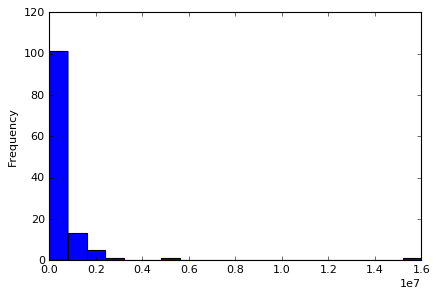

In [264]:
peppers_data["max_shu"].plot.hist(bins=20)

### JRP (Jalapeño reference point)

#### Fix malformed JRP ranges

In [190]:
# malformed jrp ranges
peppers_data["jrp"].str.contains("to").sum(), len(peppers_data)

(111, 122)

In [191]:
malformed_jrp = peppers_data[~peppers_data["jrp"].str.contains("to")]
malformed_jrp

,name,min_shu,max_shu,heat,jrp,species,origin,link
4,Peperone Di Senise,0.0,0,Mild,"-8,000 - 2,500",annuum,Italy,http://www.pepperscale.com/peperone-di-senise/
38,Cherry Bomb Pepper,2500.0,5000,Medium,0,annuum,United States,http://www.pepperscale.com/cherry-bomb-pepper
39,Cowhorn Pepper,2500.0,5000,Medium,0,annuum,South America,http://www.pepperscale.com/cowhorn-pepper
40,Guajillo Pepper,2500.0,5000,Medium,0,annuum,Mexico,http://www.pepperscale.com/guajillo-pepper
42,Chimayo Pepper,4000.0,6000,Medium,0,annuum,USA,http://www.pepperscale.com/chimayo-pepper
43,Sandia Pepper,5000.0,7000,Medium,0,annuum,USA,http://www.pepperscale.com/sandia-pepper
45,Jalapeño Pepper,2500.0,8000,Medium,0,annuum,Mexico,http://www.pepperscale.com/jalapeno-peppers
46,Purple Jalapeño Pepper,2500.0,8000,Medium,0,annuum,Mexico,http://www.pepperscale.com/purple-jalapeno-pepper
47,Chipotle Pepper,2500.0,8000,Medium,0,annuum,Mexico,http://www.pepperscale.com/chipotle-pepper
48,Puya Pepper,5000.0,8000,Medium,0,annuum,Mexico,http://www.pepperscale.com/puya-pepper


In [192]:
def sanitize_jrp(jrp):
    jrp = jrp.replace("equal", "0")
    
    if jrp == "0":
        return [0,0]
    elif "to" not in jrp:
        return [int(val.replace(",", "")) for val in jrp.split(" - ")]
    return [int(val.replace(",", "")) for val in jrp.split(" to ")]


peppers_data[["min_jrp", "max_jrp"]] = pd.DataFrame(peppers_data["jrp"].apply(sanitize_jrp).values.tolist())
peppers_data.head()

,name,min_shu,max_shu,heat,jrp,species,origin,link,min_jrp,max_jrp
0,Bell Pepper,0.0,0,Mild,"-8,000 to -2,500",annuum,Mexico and South America,http://www.pepperscale.com/bell-pepper,-8000,-2500
1,Gypsy Pepper,0.0,0,Mild,"-8,000 to -2,500",annuum,USA,http://www.pepperscale.com/gypsy-pepper,-8000,-2500
2,Purple Beauty Pepper,0.0,0,Mild,"-8,000 to -2,500",annuum,South America,http://www.pepperscale.com/purple-beauty-pepper,-8000,-2500
3,Melrose Pepper,0.0,0,Mild,"-8,000 to -2,500",annuum,USA,http://www.pepperscale.com/melrose-pepper,-8000,-2500
4,Peperone Di Senise,0.0,0,Mild,"-8,000 - 2,500",annuum,Italy,http://www.pepperscale.com/peperone-di-senise/,-8000,2500


### Categoricals

#### Heat

In [193]:
peppers_data["heat"].value_counts(dropna=False)

Medium       42
Mild         36
Super Hot    24
Extra Hot    19
              1
Name: heat, dtype: int64

In [194]:
# record needs to be sanitized -- but what heat is it?

peppers_data[peppers_data["heat"] == ""]

,name,min_shu,max_shu,heat,jrp,species,origin,link,min_jrp,max_jrp
51,Black Hungarian Pepper,5000.0,10000,,0 to 4,annuum,Hungary,http://www.pepperscale.com/black-hungarian-pepper,0,4


In [195]:
peppers_data[(peppers_data["min_shu"] >= 5000) & (peppers_data["max_shu"] <= 10000)]

,name,min_shu,max_shu,heat,jrp,species,origin,link,min_jrp,max_jrp
43,Sandia Pepper,5000.0,7000,Medium,0,annuum,USA,http://www.pepperscale.com/sandia-pepper,0,0
48,Puya Pepper,5000.0,8000,Medium,0,annuum,Mexico,http://www.pepperscale.com/puya-pepper,0,0
50,Hungarian Wax Pepper,5000.0,10000,Medium,0 to 4,annuum,Hungary,http://www.pepperscale.com/hungarian-wax-pepper,0,4
51,Black Hungarian Pepper,5000.0,10000,,0 to 4,annuum,Hungary,http://www.pepperscale.com/black-hungarian-pepper,0,4
52,Aleppo Pepper,10000.0,10000,Medium,0 to 4,annuum,Syria,http://www.pepperscale.com/aleppo-pepper,0,4


In [196]:
peppers_data["heat"] = peppers_data["heat"].apply(lambda x: x if x != "" else "Medium")
peppers_data["heat"].value_counts()

Medium       43
Mild         36
Super Hot    24
Extra Hot    19
Name: heat, dtype: int64

#### Species

In [197]:
peppers_data["species"].value_counts()

annuum        72
chinense      36
baccatum       7
frutescens     3
N/A            2
pubescens      2
Name: species, dtype: int64

In [198]:
peppers_data["species"] = peppers_data["species"].apply(lambda x: x if x != "N/A" else None)
peppers_data["species"].value_counts(dropna=False)

annuum        72
chinense      36
baccatum       7
frutescens     3
pubescens      2
NaN            2
Name: species, dtype: int64

#### Origin

In [199]:
peppers_data["origin"].value_counts()

USA                              24
Mexico                           17
South America                    10
Trinidad                          7
United States                     7
Peru                              7
United Kingdom                    6
India                             6
Italy                             4
Caribbean                         4
Spain                             3
Hungary                           3
N/A                               2
Japan                             2
Brazil                            2
Africa                            2
Pakistan                          1
French Guyana                     1
Mexico and South America          1
China                             1
Phillipines                       1
Unknown                           1
Panama                            1
Syria                             1
Italy, Cuba                       1
Jamaica                           1
France                            1
Mexico, <br />\nSouth Americ

In [17]:
def sanitize_origin(origin):
    if pd.isnull(origin):
        return origin
    elif "Mexico" in origin and "South America" in origin:
        return "Mexico, South America"
    elif origin in ["USA", "United States"]:
        return "United States"
    elif origin not in ["N/A", "Unknown"]:
        return origin
    
peppers_data["origin"] = peppers_data["origin"].apply(sanitize_origin)
peppers_data["origin"].value_counts(dropna=False)

United States            31
Mexico                   17
South America            10
Trinidad                  7
Peru                      7
United Kingdom            6
India                     6
Caribbean                 4
Italy                     4
Hungary                   3
Spain                     3
NaN                       3
Mexico, South America     2
Brazil                    2
Japan                     2
Africa                    2
French Guyana             1
China                     1
Phillipines               1
Panama                    1
Pakistan                  1
Australia                 1
Italy, Cuba               1
Jamaica                   1
Costa Rica                1
Syria                     1
Bolivia                   1
Thailand                  1
France                    1
Name: origin, dtype: int64

##### Add region

Regions from here: https://www.thoughtco.com/official-listing-of-countries-world-region-1435153

In [18]:
def add_region(origin):
    if origin in ["Italy", "United Kingdom", "Spain", "Hungary", "France"]:
        return "Europe"
    elif origin in ["United States", "Mexico"]:
        return "North America"
    elif origin in ["Trinidad", "Caribbean", "Jamaica",  "Panama", "Costa Rica"]:
        return "Central America and the Caribbean"
    elif origin in ["Peru", "Brazil", "Bolivia", "French Guyana", "South America"]:
        return "South America"
    elif origin in ["India", "Pakistan", "Thailand", "Japan", "China", "Phillipines"]:
        return "Asia"
    elif origin in ["Africa"]:
        return "Africa"
    elif origin in ["Australia"]:
        return "Australia and Oceania"
    elif origin in ["Syria"]:
        return "Middle East"
    elif pd.notnull(origin):
        return "Multi-Region"
    
peppers_data["region"] = peppers_data["origin"].apply(add_region)
peppers_data[["origin", "region"]].drop_duplicates()

,origin,region
0,"Mexico, South America",Multi-Region
1,United States,North America
2,South America,South America
4,Italy,Europe
8,Japan,Asia
11,None,None
12,Caribbean,Central America and the Caribbean
17,"Italy, Cuba",Multi-Region
18,Spain,Europe
23,Africa,Africa


## Convert to JSON

References:
- https://json-ld.org/spec/latest/json-ld-api-best-practices/
- https://www.sitepoint.com/google-maps-json-file/

In [234]:
JSON_COLS = ["name", "species", "heat", "region", "origin", "min_shu", "max_shu", "min_jrp", "max_jrp", "link"]
json_peppers_data = peppers_data[JSON_COLS]
json_peppers_data.head()

,name,species,heat,region,origin,min_shu,max_shu,min_jrp,max_jrp,link
0,Bell Pepper,annuum,Mild,Multi-Region,"Mexico, South America",0.0,0,-8000,-2500,http://www.pepperscale.com/bell-pepper
1,Gypsy Pepper,annuum,Mild,North America,United States of America,0.0,0,-8000,-2500,http://www.pepperscale.com/gypsy-pepper
2,Purple Beauty Pepper,annuum,Mild,South America,South America,0.0,0,-8000,-2500,http://www.pepperscale.com/purple-beauty-pepper
3,Melrose Pepper,annuum,Mild,North America,United States of America,0.0,0,-8000,-2500,http://www.pepperscale.com/melrose-pepper
4,Peperone Di Senise,annuum,Mild,Europe,Italy,0.0,0,-8000,2500,http://www.pepperscale.com/peperone-di-senise/


In [262]:
header_info = """{
    "source": "https://www.pepperscale.com/hot-pepper-list/",
    "contact": "https://github.com/alemosie",
    "last_updated": "%s",
    "peppers":
""" % (datetime.now())

with open ("data/peppers.json", "w") as json_file:
    json_file.write(header_info)
    json_file.write(json_peppers_data.to_json(orient='records'))
    json_file.write("}")